In [24]:
import streamlit as st
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pickle

In [25]:

from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [38]:
daily_temp = pd.read_csv("daily-minimum-temperatures-in-me.csv")
daily_temp["Date"] = pd.to_datetime(daily_temp["Date"])
daily_temp["Date"] = daily_temp["Date"].dt.strftime("%Y-%m")
daily_temp = daily_temp.set_index("Date")
daily_temp["Daily minimum temperatures"] = pd.to_numeric(daily_temp["Daily minimum temperatures"], errors="coerce")
daily_temp.dropna(subset=["Daily minimum temperatures"], inplace=True)

#### Monthly minimum-temperature average over 10 years

In [27]:
monthly_avg_temp = daily_temp.groupby("Date")["Daily minimum temperatures"].mean().reset_index()
monthly_avg_temp.rename(columns={"Daily minimum temperatures": "MinTemp"}, inplace=True)
monthly_avg_temp.to_csv("monthly_min_avg_temp.csv", index=False)

In [22]:
xticks = np.arange(0, len(monthly_avg_temp), step=6)
xticks_labels = monthly_avg_temp["Date"].loc[xticks]
plt.figure(figsize=(15,4))
plt.plot(monthly_avg_temp["Date"], monthly_avg_temp["MinTemp"], label="", color ="purple")
plt.title("Monthly minimum temperature average")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.xticks(xticks, xticks_labels, rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [23]:
monthly_avg_temp.set_index("Date", inplace=True)

### Ljung-Box Test

In [7]:
# Checking for White Noice adn Random Walk
lb_test = acorr_ljungbox(monthly_avg_temp["MinTemp"], lags=[10], return_df=True)
lb_test

,lb_stat,lb_pvalue
10,381.902949,6.659692e-76


In [8]:
6.659692e-76 < 0.05

True

#### Data is not white noise. This means there is structure/pattern in the data — useful for time series modeling like ARIMA.

## Classical Decomposition

In [9]:
decomposition = seasonal_decompose(monthly_avg_temp["MinTemp"], model="additive", period=12)

In [10]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [15]:
seasonal.to_csv("seasonality.csv")

In [11]:
plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(monthly_avg_temp.index, monthly_avg_temp["MinTemp"], label = "Original", color="purple")
plt.xticks(xticks, xticks_labels, rotation=45)
plt.legend(loc="upper left")
plt.subplot(412)
plt.plot(monthly_avg_temp.index, trend, label="Trend", color="purple")
plt.xticks(xticks, xticks_labels, rotation=45)
plt.legend(loc="upper left")
plt.subplot(413)
plt.plot(monthly_avg_temp.index, seasonal, label="Seasonality", color="purple")
plt.xticks(xticks, xticks_labels, rotation=45)
plt.legend(loc="upper left")
plt.subplot(414)
plt.plot(monthly_avg_temp.index, residual, label="Residual", color="purple")
plt.xticks(xticks, xticks_labels, rotation=45)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

### Checking Stationarity

## ADF Test Function

In [12]:
def adf_test(series):
    test = adfuller(series)
    print(f"ADF Statistics: {round(test[0], 3)}")
    print(f"p_value: {round(test[1], 3)}")
    for key, value in test[4].items():
        print(f"{key}: {round(value, 3)}")

## KPSS Test Function

In [13]:
def kpss_test(series):
    test = kpss(series, regression="ct")
    print(f"KPSS Statistics: {round(test[0], 3)}")
    print(f"p_value: {round(test[0], 3)}")
    for key, value in test[3].items():
        print(f"{key}: {value}")

In [14]:
adf_test(monthly_avg_temp["MinTemp"])

ADF Statistics: -1.874
p_value: 0.344
1%: -3.494
5%: -2.889
10%: -2.582


In [15]:
kpss_test(monthly_avg_temp["MinTemp"])

KPSS Statistics: 0.025
p_value: 0.025
10%: 0.119
5%: 0.146
2.5%: 0.176
1%: 0.216


#### Adf test says non stationary and kpss suggest slightly stationary. Therefore, the data is not entirely stationary and requires seasonal differencing. 

In [16]:
seasonal_diff = monthly_avg_temp["MinTemp"].diff(periods=12).dropna()
adf_test(seasonal_diff)

ADF Statistics: -4.704
p_value: 0.0
1%: -3.5
5%: -2.892
10%: -2.583


In [17]:
kpss_test(seasonal_diff)

KPSS Statistics: 0.063
p_value: 0.063
10%: 0.119
5%: 0.146
2.5%: 0.176
1%: 0.216


### Now the data is stataionary

#### Plotting ACF and PACF

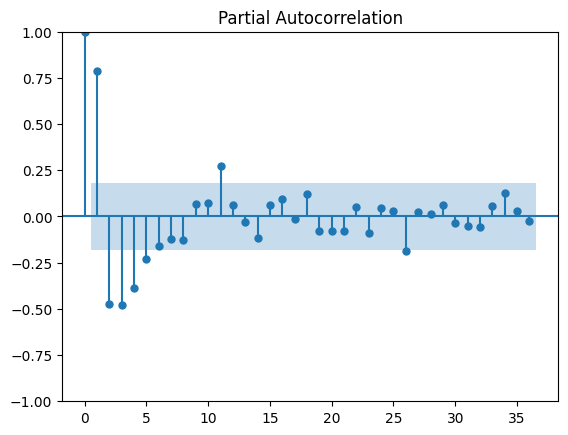

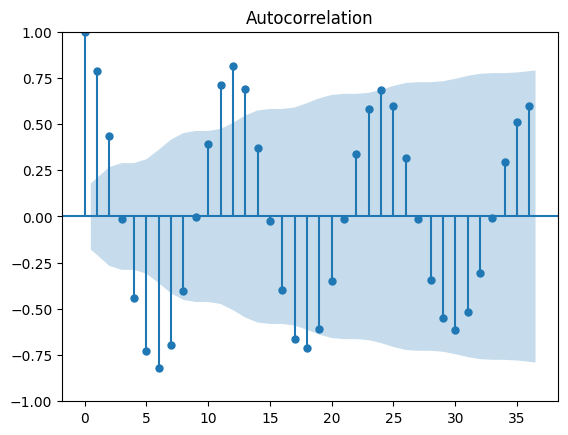

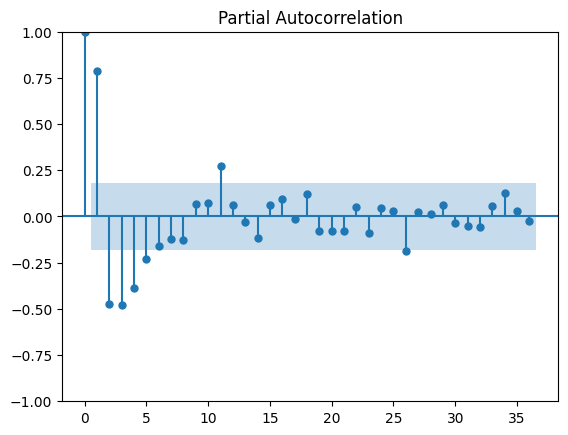

In [18]:
plot_acf(monthly_avg_temp["MinTemp"], lags=36)
plot_pacf(monthly_avg_temp["MinTemp"], lags=36)

In [40]:
model = auto_arima(
    monthly_avg_temp["MinTemp"],
    seasonal = True,
    m=12,
    d=None,
    D=None,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=415.260, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=617.656, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=418.301, Time=0.32 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=488.835, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=931.431, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=367.747, Time=0.60 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=372.030, Time=0.30 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=369.933, Time=1.54 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=373.037, Time=1.62 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=444.742, Time=0.26 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=462.807, Time=0.33 sec
 ARIMA(3,0,2)(0,0,1)[12] intercept   : AIC=394.362, Time=0.71 sec
 ARIMA(2,0,3)(0,0,1)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AI

## SARIMA

In [19]:
# Splittign the data into two components, train and test data, to test the predictions
train_data, test_data = monthly_avg_temp["MinTemp"][:-30], monthly_avg_temp["MinTemp"][-30:]

In [37]:
model = SARIMAX(
    train_data, 
    order=(2,1,2), 
    seasonal_order=(0,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()

In [38]:
predictions = results.predict(
    start=len(train_data),
    end=len(train_data) + len(test_data)-1,
    dynamic=False
)

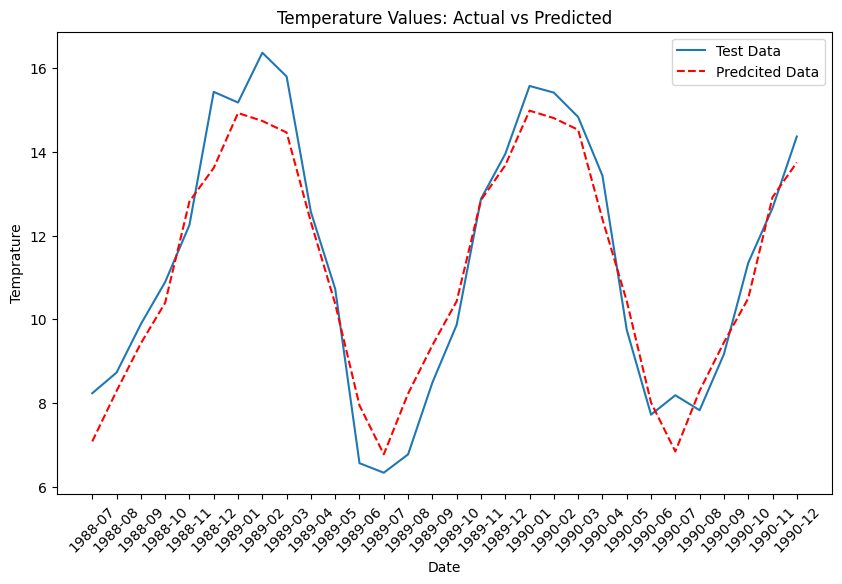

RMSE: 0.84
MAE: 0.7036843232768468


In [47]:
plt.figure(figsize=(10,6))
plt.plot(test_data.index, test_data, label= "Test Data")
plt.plot(test_data.index, predictions, color="red", linestyle="--", label="Predcited Data")
plt.title("Temperature Values: Actual vs Predicted")
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Temprature')
plt.legend()
plt.show()

rmse = round(np.sqrt(mean_squared_error(test_data, predictions)), 2)
print('RMSE:', rmse)
mae = mean_absolute_error(test_data, predictions)
print('MAE:',mae)

#### The model is accurate predicitons with lower rmse value. So it is a best fit

## Forecasting next 12 months

In [50]:
actual_model = SARIMAX(
    monthly_avg_temp["MinTemp"],
    order=(2,1,2),
    seasonal_order=(0,1,1,12),
    enforce_invertibility=False,
    enforce_stationarity=False
)
results2 = actual_model.fit()

In [59]:
# Saving the model and loading the model
with open("sarimax_model.pkl", "wb") as f:
    pickle.dump(results2, f)

with open("sarimax_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

In [1]:
forecast = loaded_model.get_forecast(steps=12)
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

NameError: name 'loaded_model' is not defined

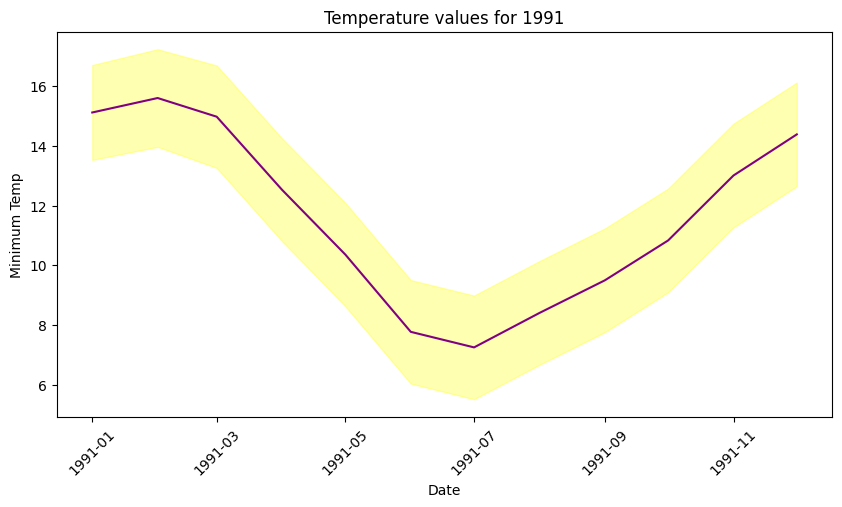

In [91]:
plt.figure(figsize=(10,5))
plt.plot(forecast_values.index, forecast_values, color="purple")

plt.fill_between(
    forecast_ci.index,
    forecast_ci["lower MinTemp"],
    forecast_ci["upper MinTemp"],
    color="yellow",
    alpha=0.3
)

plt.title("Temperature values for 1991")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Minimum Temp")
plt.show()